# Initialization

## Identity

COMS 6998 Practical Deep Learning System Performance

Final Project

Praditya Raudi Avinanto (pra2118)

Rifqi Luthfan (rl3154)

## Import libraries

In [1]:
import os
import copy

# datetime
from datetime import datetime, timedelta
import time

# linear algebra
import numpy as np 
import scipy

# data processing
import pandas as pd 
from collections import defaultdict

# data visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
# If using Google Colab
from google.colab import drive
BASE_PATH = '/content/drive'
# drive.mount(BASE_PATH)

PROJECT_PATH = os.path.join(BASE_PATH, "MyDrive","2021-09 Fall Semester","COMS 6998 Practical Deep Learning System Performance","Projects", "pytorch-quantization")
os.chdir(PROJECT_PATH)

# Analysis

## Combining all the records in one place

In [3]:
compiled_df = pd.read_csv('compiled_val_acc.csv')

## Post Training Quantization Validation Accuracy Results

In [4]:
(pd.pivot_table(compiled_df[(compiled_df['quantization'].isin(['base','ptq']))], 
                values='val_acc', index=['quantization', 'num_bits'], columns=['dataset', 'model'])
.sort_index(level=[0,1], ascending=[True,False]))

dataset                cifar10          imagenette         
model                 resnet18 resnet50   resnet18 resnet50
quantization num_bits                                      
base         32         0.8039   0.8460     0.9465   0.9603
ptq          8          0.7968   0.2418     0.9439   0.8089
             7          0.7926   0.2377     0.9404   0.7911
             6          0.7539   0.1806     0.9027   0.7554
             5          0.5153   0.1378     0.2550   0.3654
             4          0.1336   0.1061     0.1284   0.0721

## Quantization Aware Training Validation Accuracy Results

In [5]:
(pd.pivot_table(compiled_df[(compiled_df['quantization'].isin(['base','qat']))], 
                values='val_acc', index=['quantization', 'num_bits'], columns=['dataset', 'model'])
.sort_index(level=[0,1], ascending=[True,False]))

dataset                cifar10          imagenette         
model                 resnet18 resnet50   resnet18 resnet50
quantization num_bits                                      
base         32         0.8039   0.8460     0.9465   0.9603
qat          8          0.8057   0.7934     0.9439   0.9513
             7          0.8118   0.7908     0.9401   0.9442
             6          0.7689   0.7334     0.7689   0.8433
             5          0.6344   0.4095     0.8061   0.4438
             4          0.2257   0.0990     0.1332   0.1129

## Convergence of Quantitative Aware Training

In [6]:
BASE_CKPT_DIR = 'checkpoint'
training_hist = []

for ck in (os.listdir(BASE_CKPT_DIR)):
    for pt in (os.listdir(f"{BASE_CKPT_DIR}/{ck}")):
        if os.path.isdir(f"{BASE_CKPT_DIR}/{ck}/{pt}"):
            temp_df = pd.read_csv(f"{BASE_CKPT_DIR}/{ck}/{pt}/train_logs.csv")
            temp_df['epoch'] = range(len(temp_df))
            temp_df['quantization'] = pt
            temp_df['dataset_model'] = ck
            training_hist.append(temp_df)

In [7]:
qat_plot = pd.concat(training_hist).melt(id_vars=['quantization', 'dataset_model', 'epoch'], var_name='metric_name', value_name='metric_value')
qat_plot

,quantization,dataset_model,epoch,metric_name,metric_value
0,base_model,cifar10_resnet18,0,train_loss,0.930166
1,base_model,cifar10_resnet18,1,train_loss,0.490442
2,base_model,cifar10_resnet18,2,train_loss,0.335670
3,base_model,cifar10_resnet18,3,train_loss,0.225211
4,base_model,cifar10_resnet18,4,train_loss,0.171859
...,...,...,...,...,...
855,qat8bit,imagenette_resnet50,5,val_acc,0.941911
856,qat8bit,imagenette_resnet50,6,val_acc,0.944713
857,qat8bit,imagenette_resnet50,7,val_acc,0.951847
858,qat8bit,imagenette_resnet50,8,val_acc,0.952866


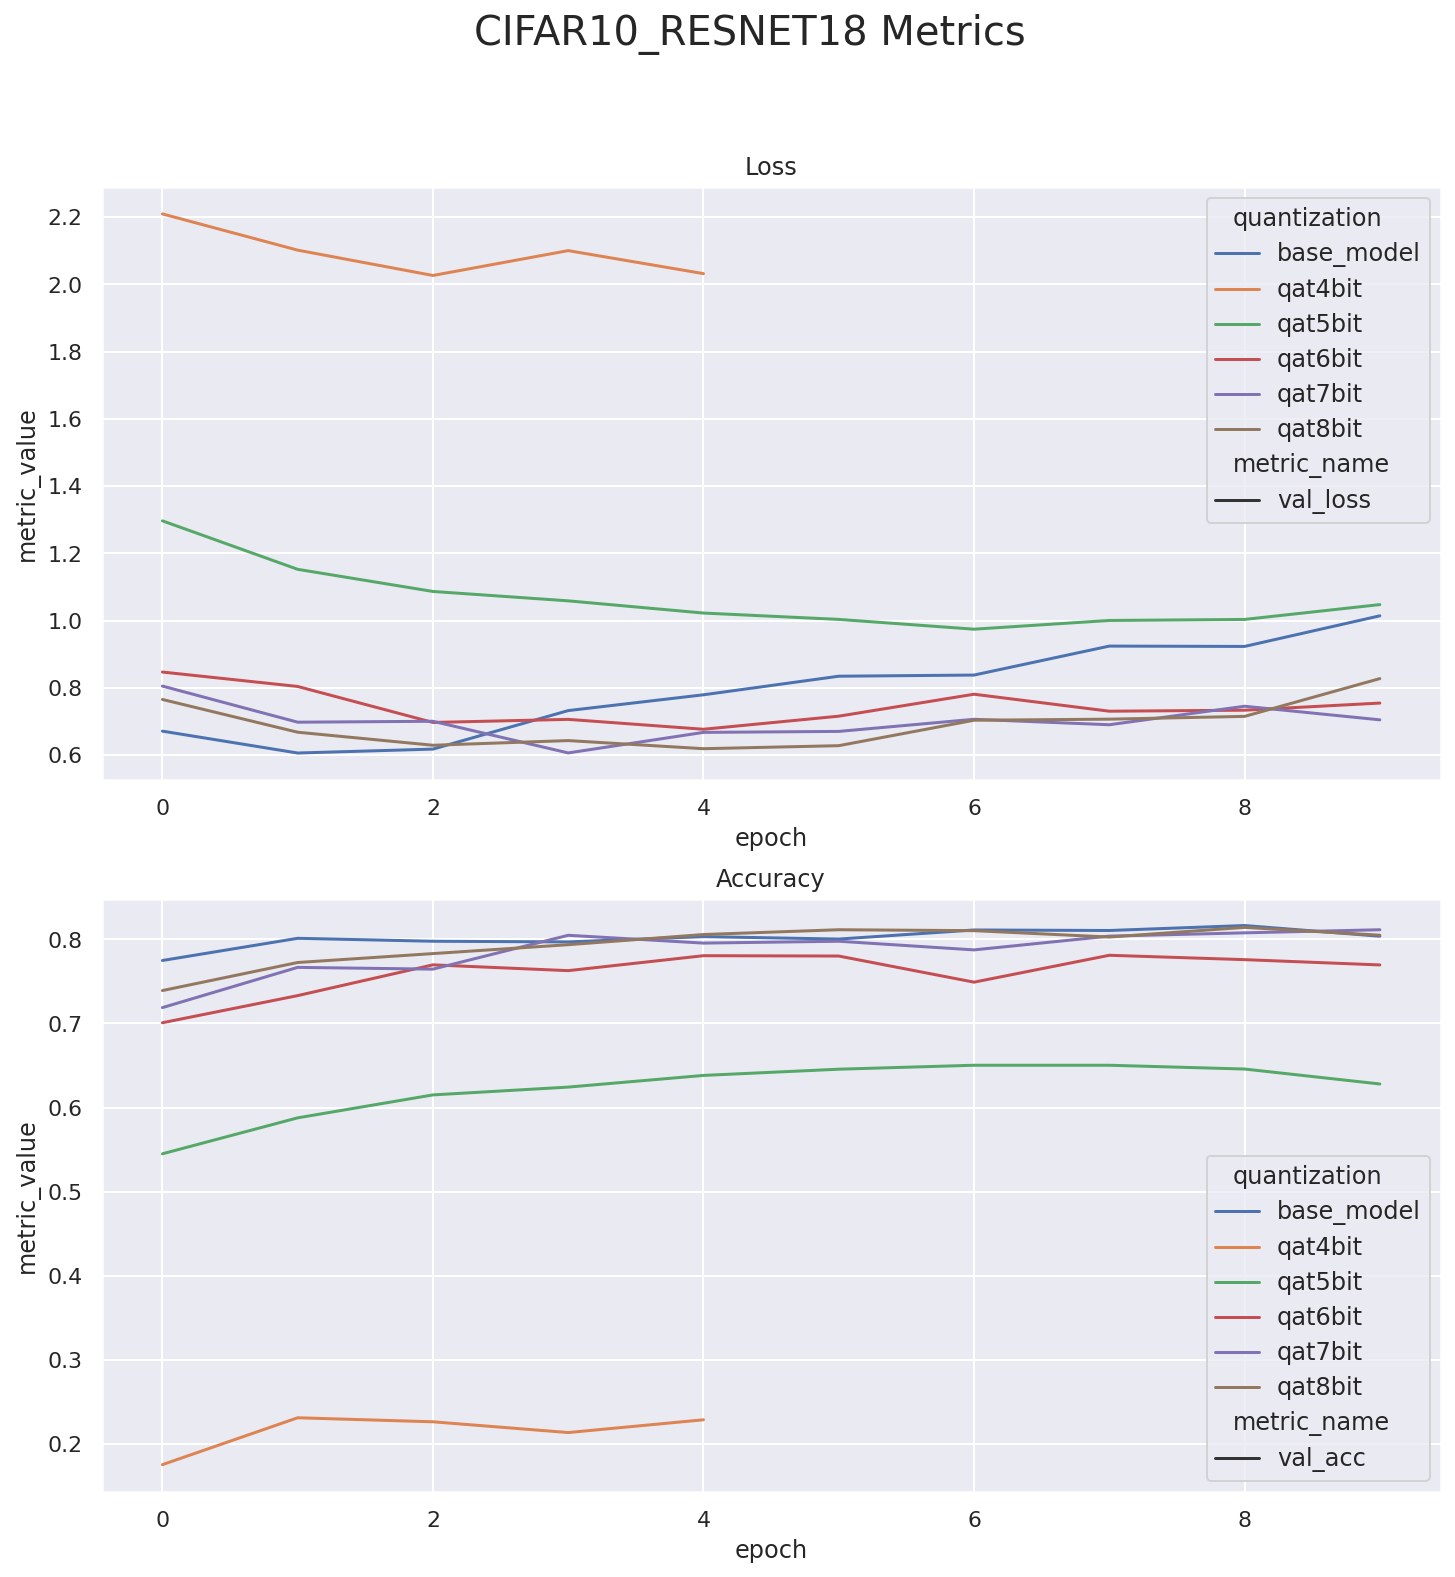

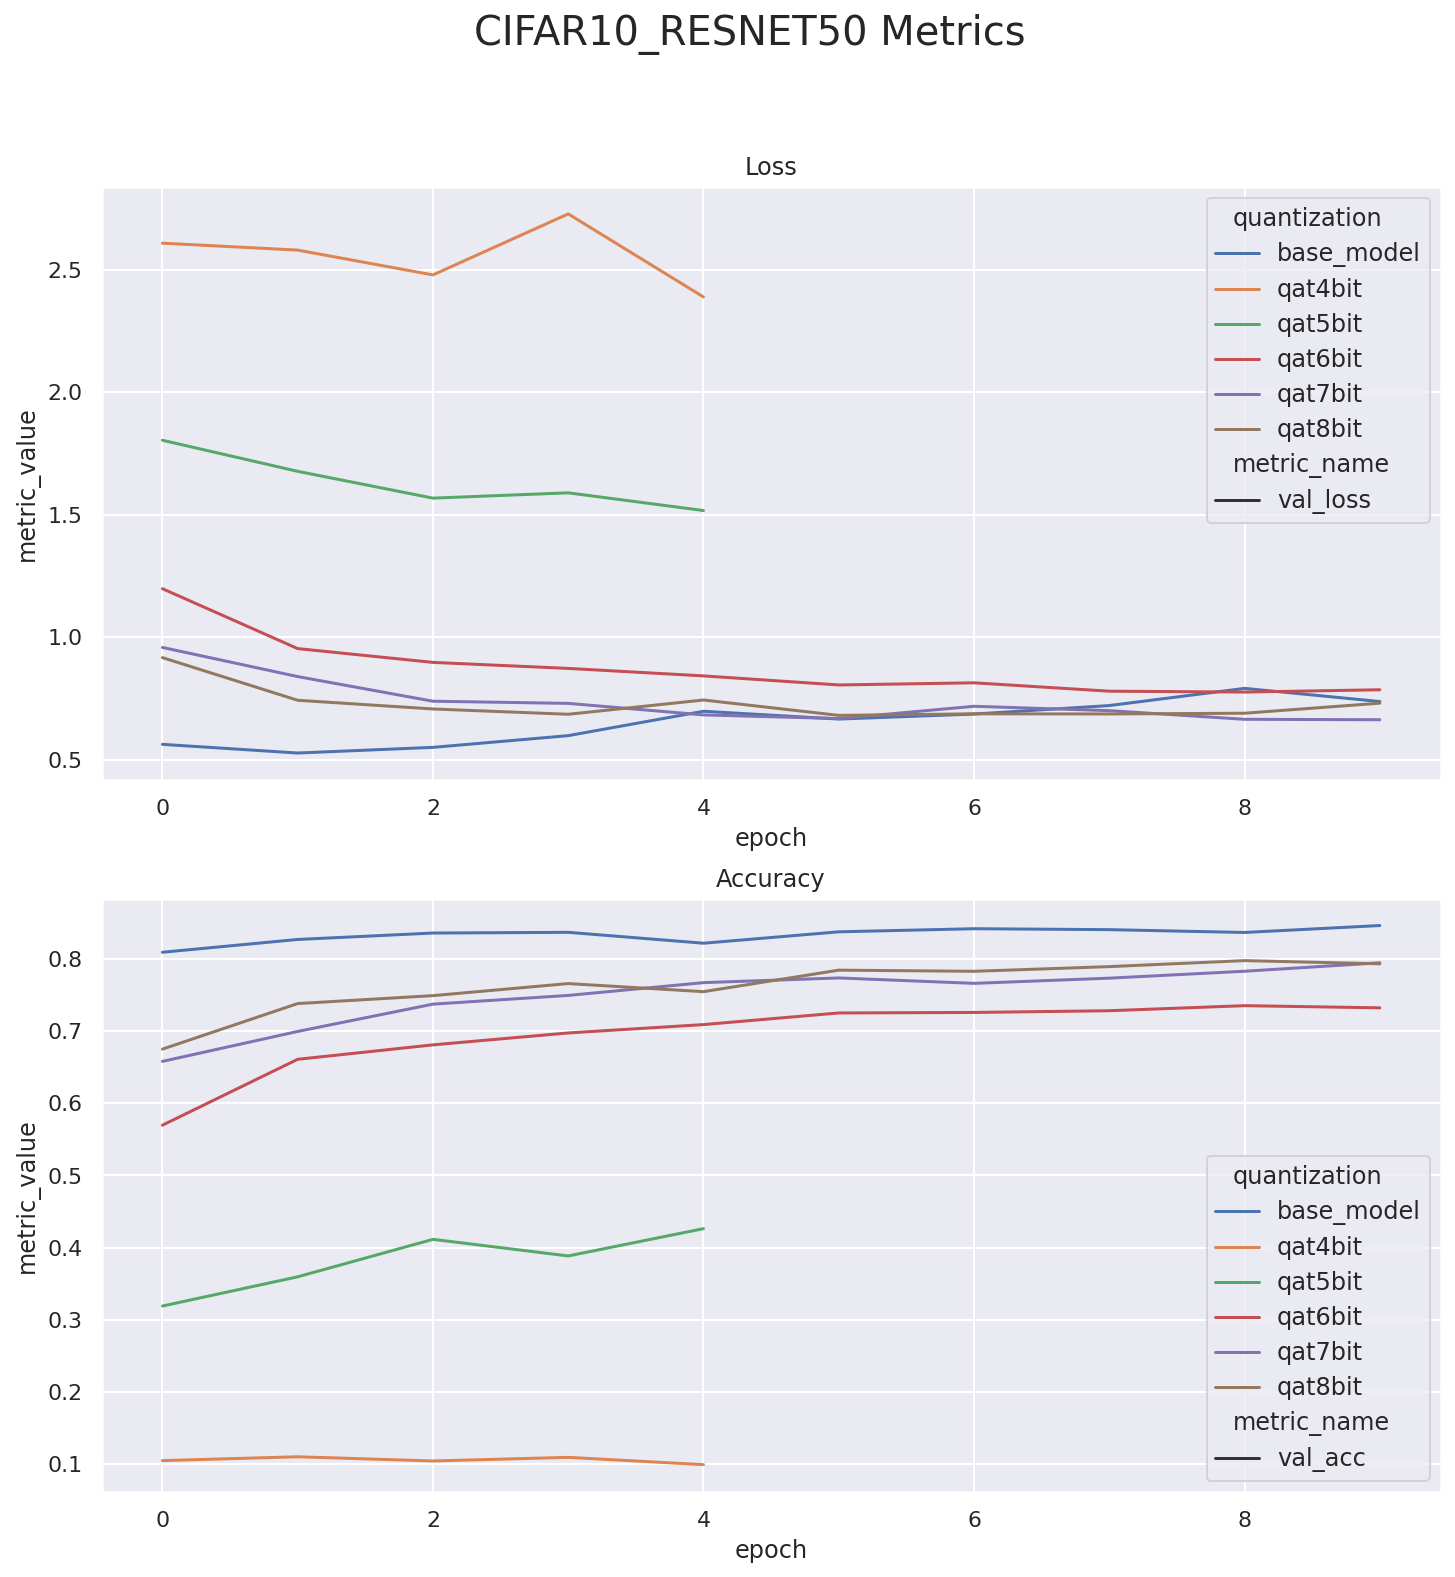

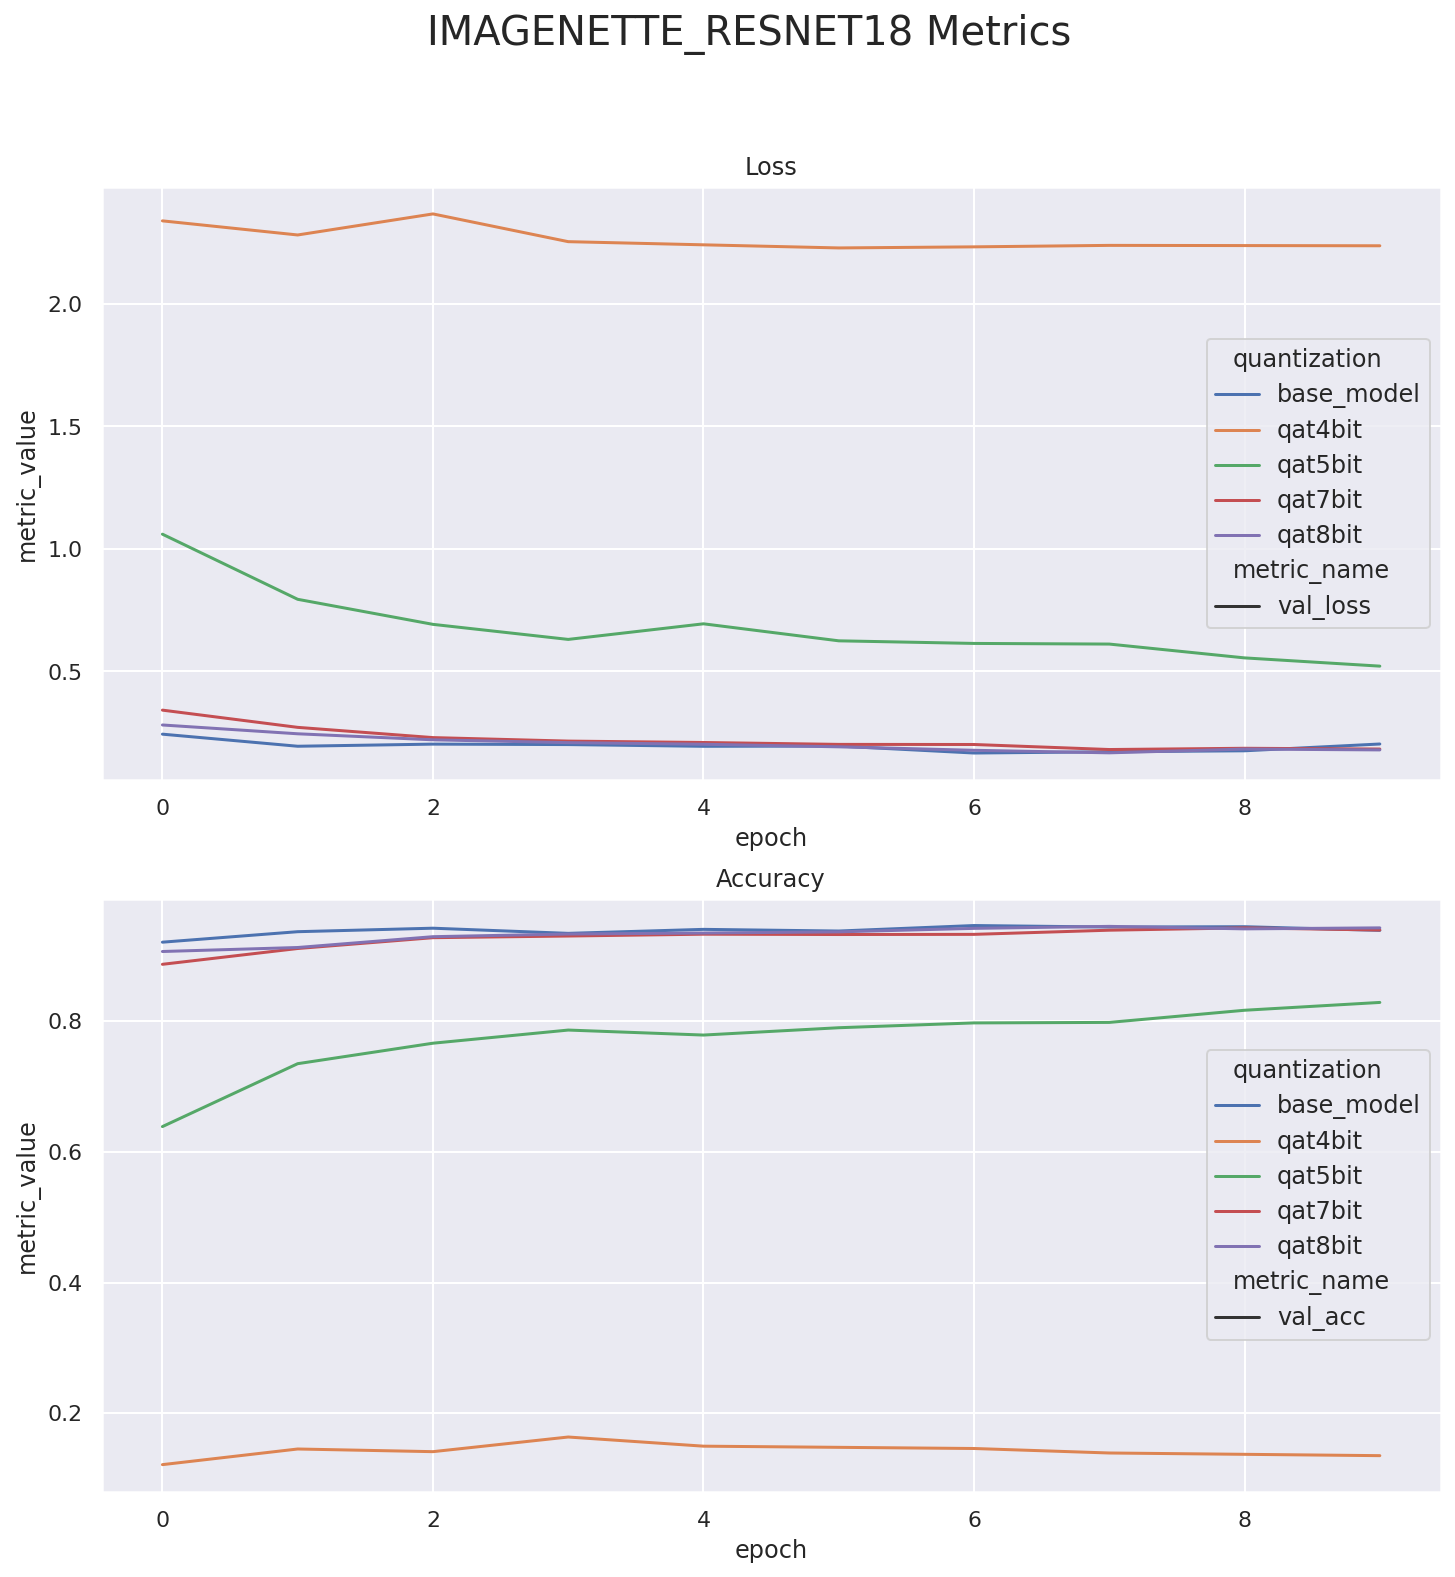

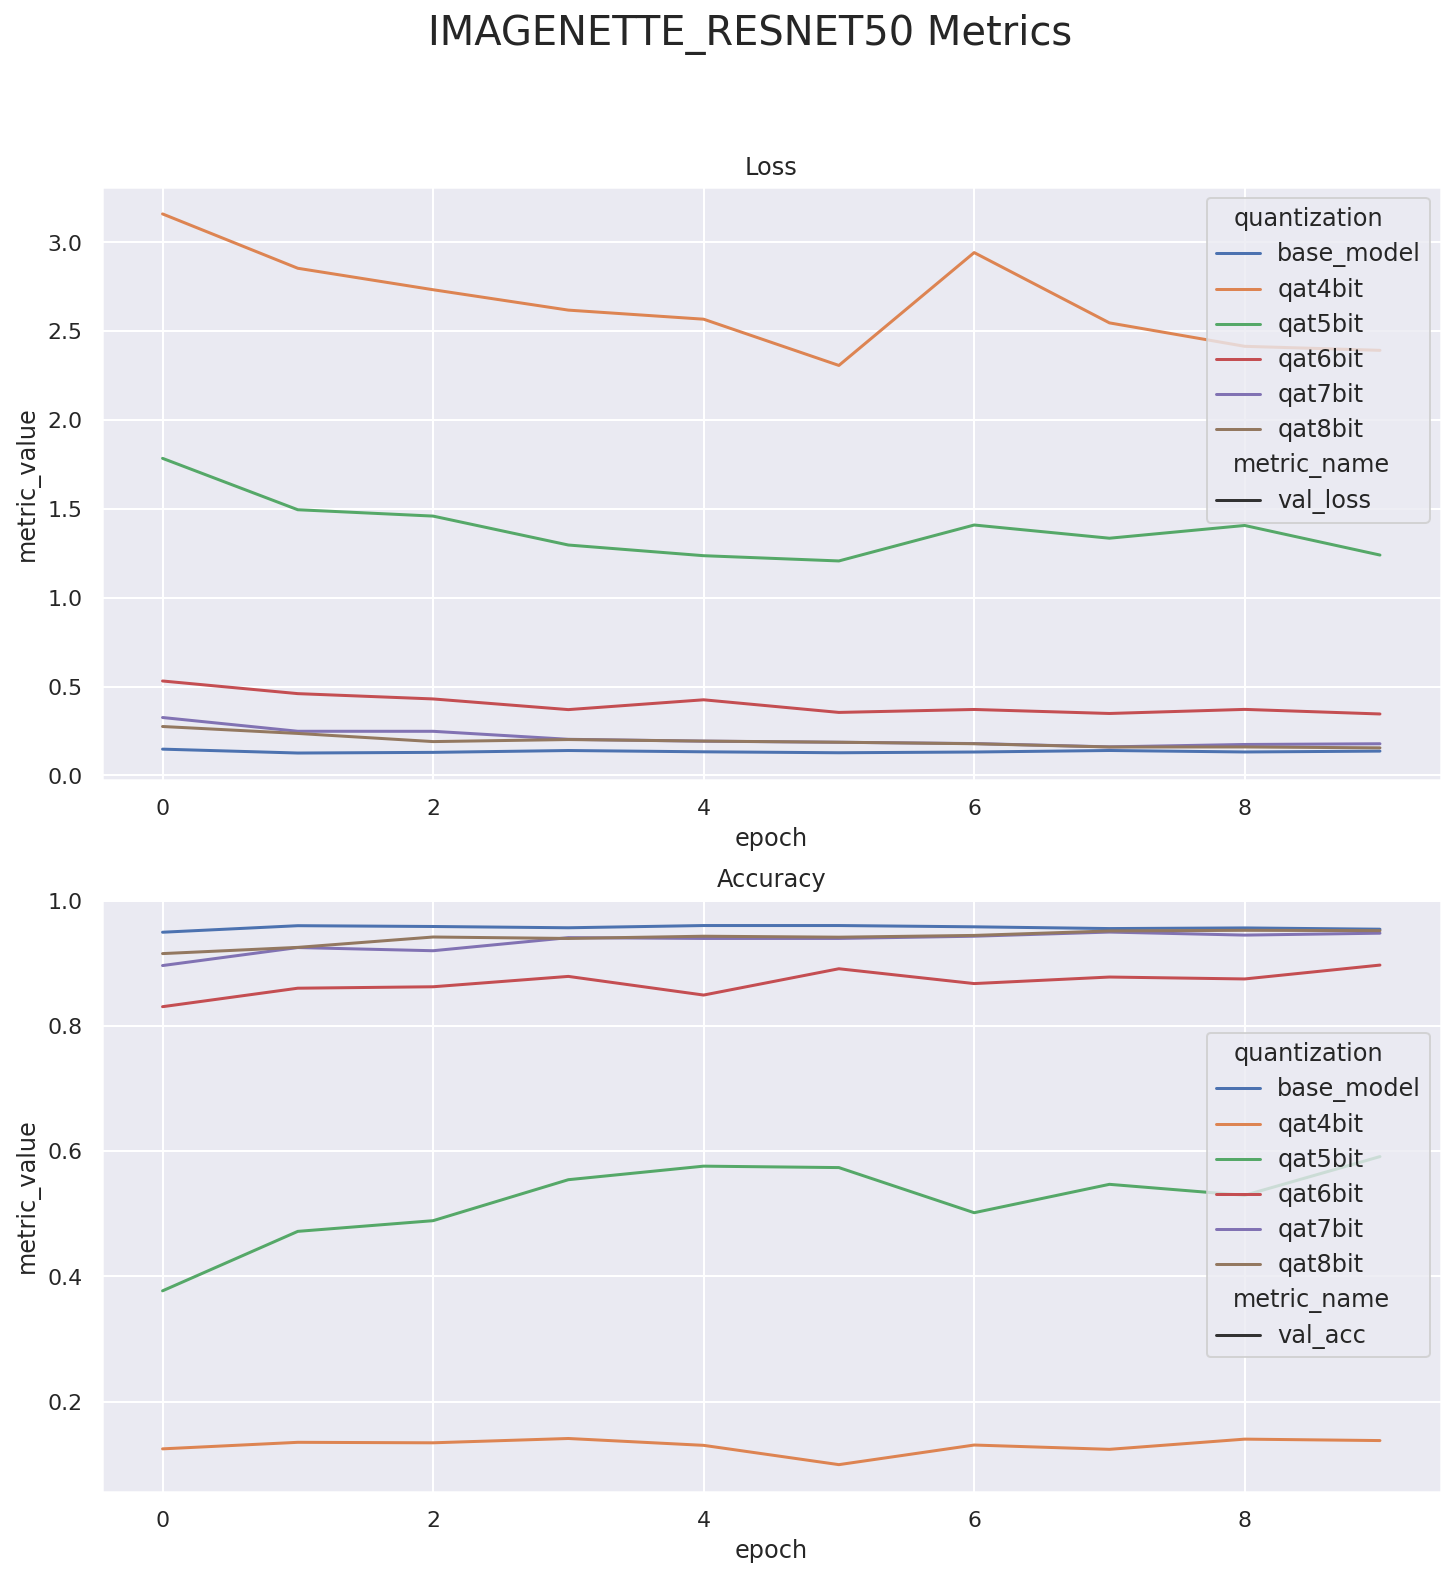

In [8]:
# Per Dataset Per Model

for ds in qat_plot['dataset_model'].unique():
    fig, ax = plt.subplots(figsize=(12,12), nrows=2, ncols=1)
    sns.lineplot(data=qat_plot[(qat_plot['dataset_model']==ds)&
                               (qat_plot['metric_name'].str.contains('val_loss'))], 
                    x='epoch', y='metric_value', hue='quantization', style='metric_name', ax=ax[0])
    sns.lineplot(data=qat_plot[(qat_plot['dataset_model']==ds)&
                               (qat_plot['metric_name'].str.contains('val_acc'))], 
                    x='epoch', y='metric_value', hue='quantization', style='metric_name', ax=ax[1])
    fig.suptitle(f"{ds.upper()} Metrics", fontsize=20)
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    plt.savefig(f'figures/effect_of_diff_bits/{ds}.png', dpi=500)

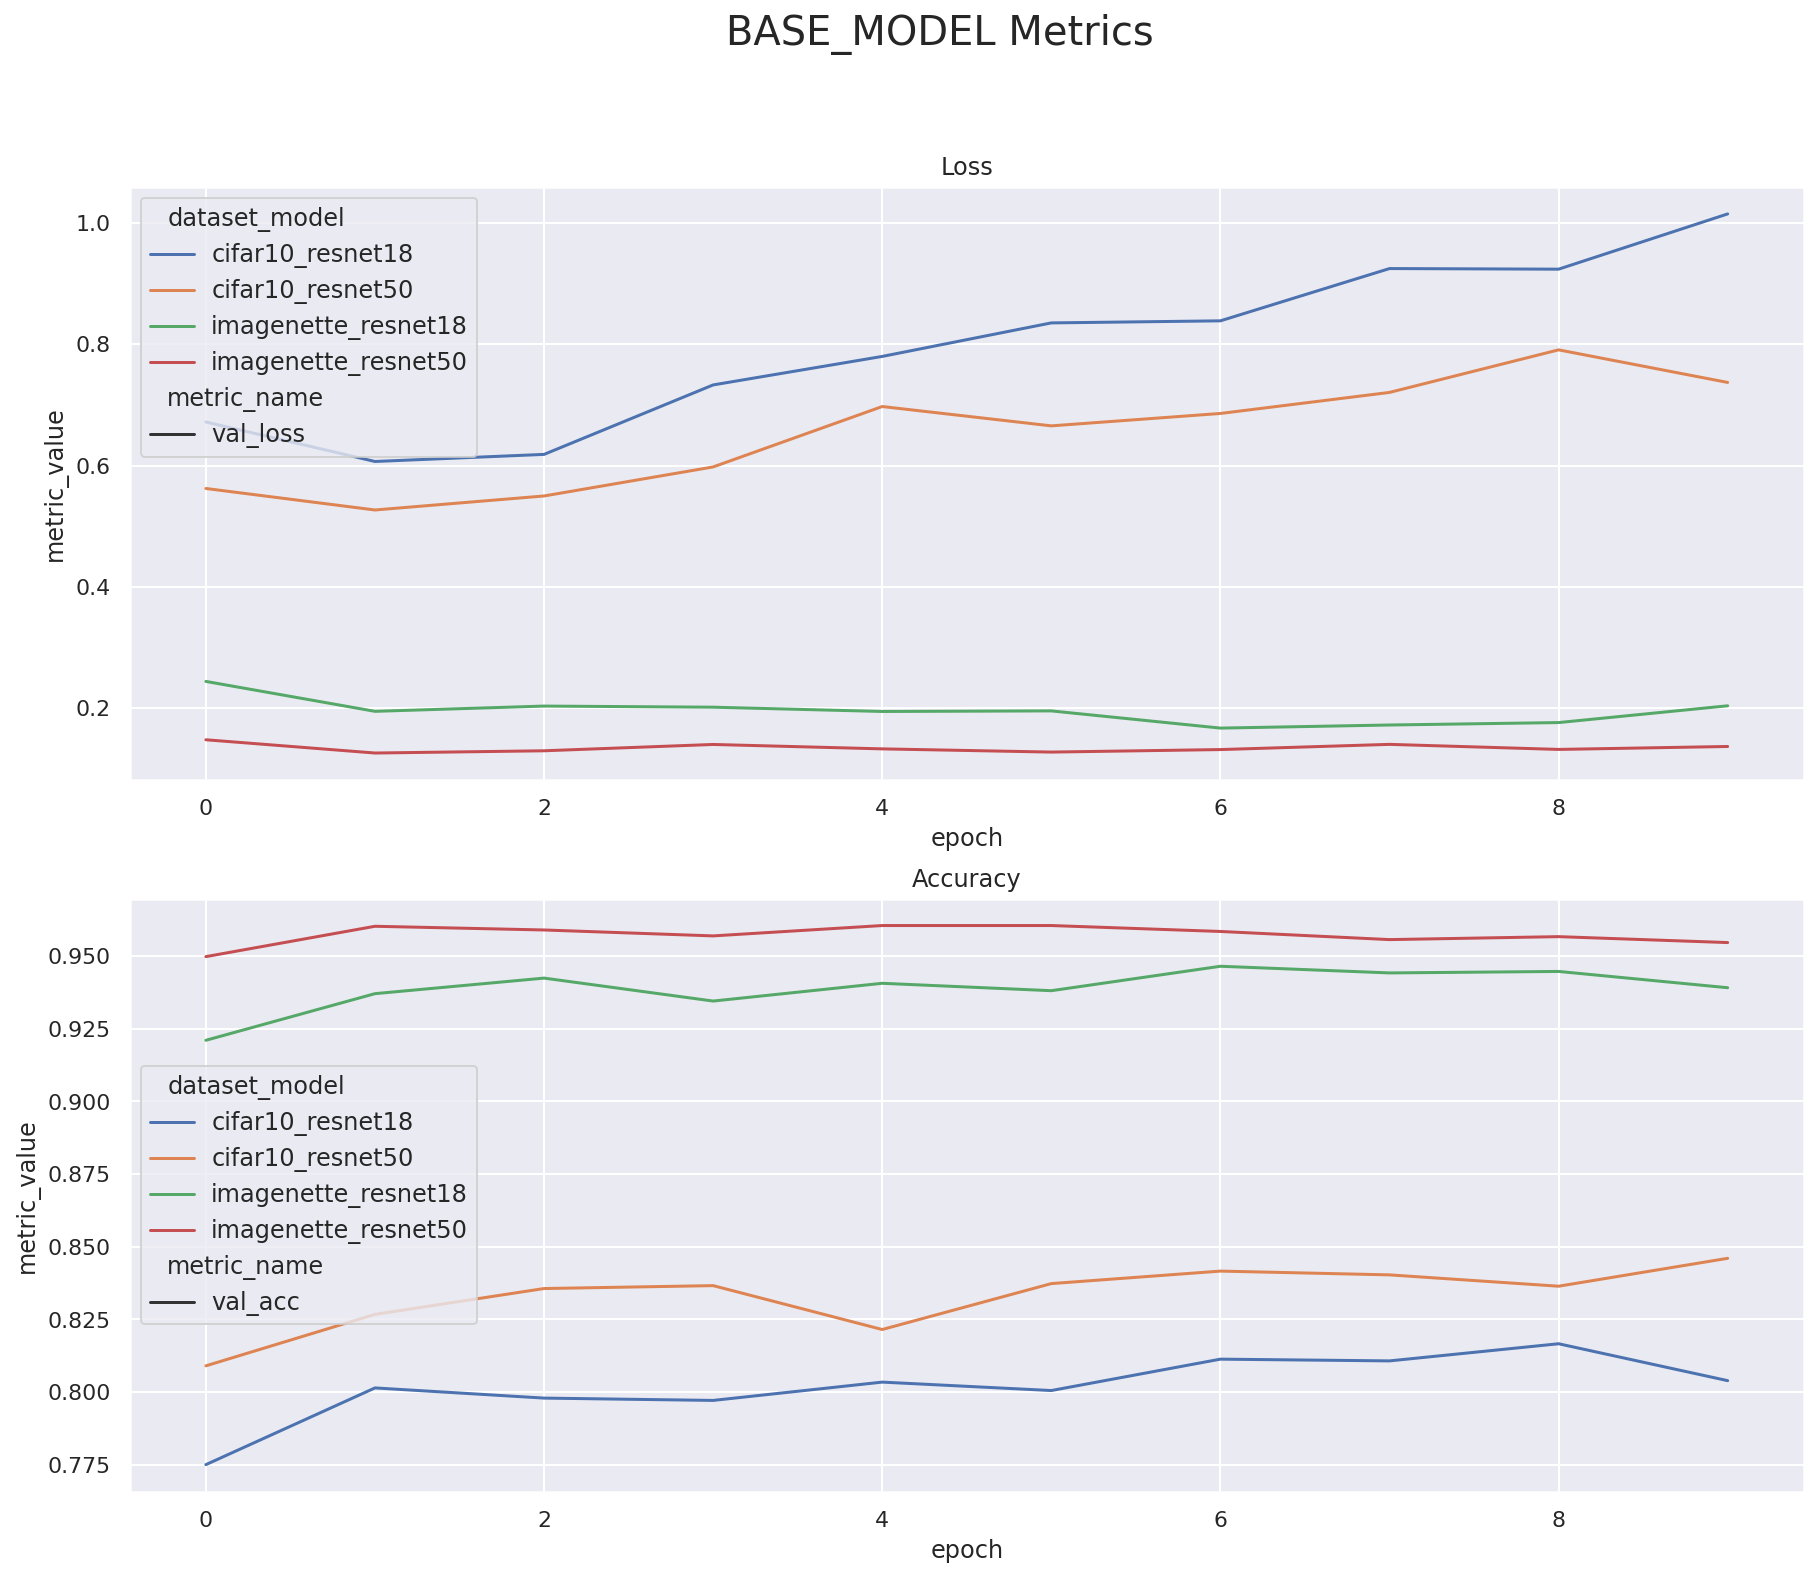

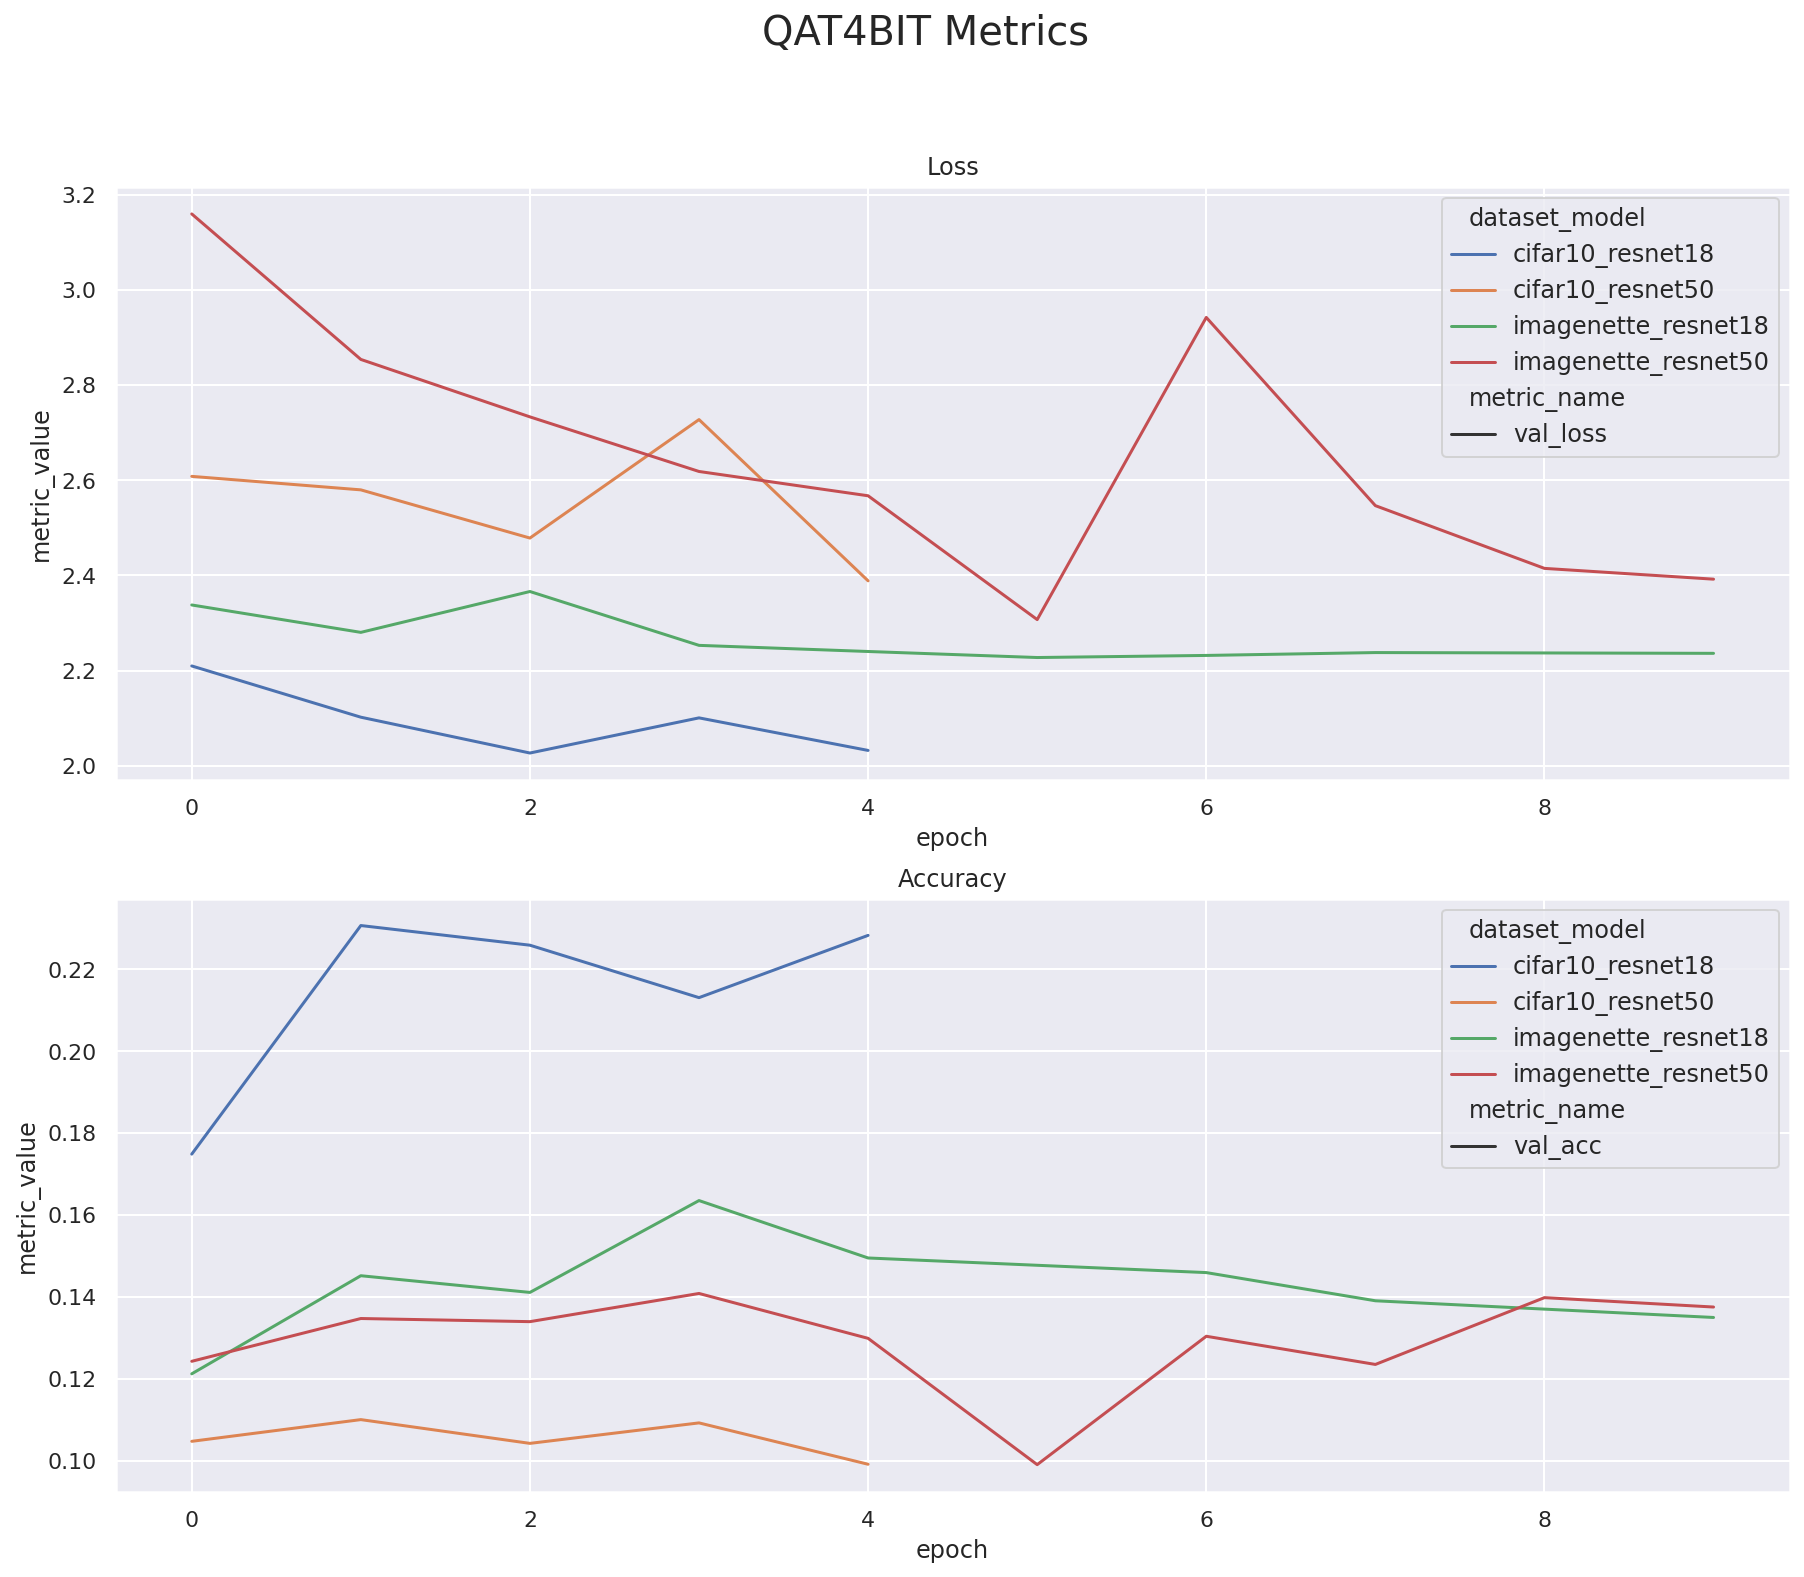

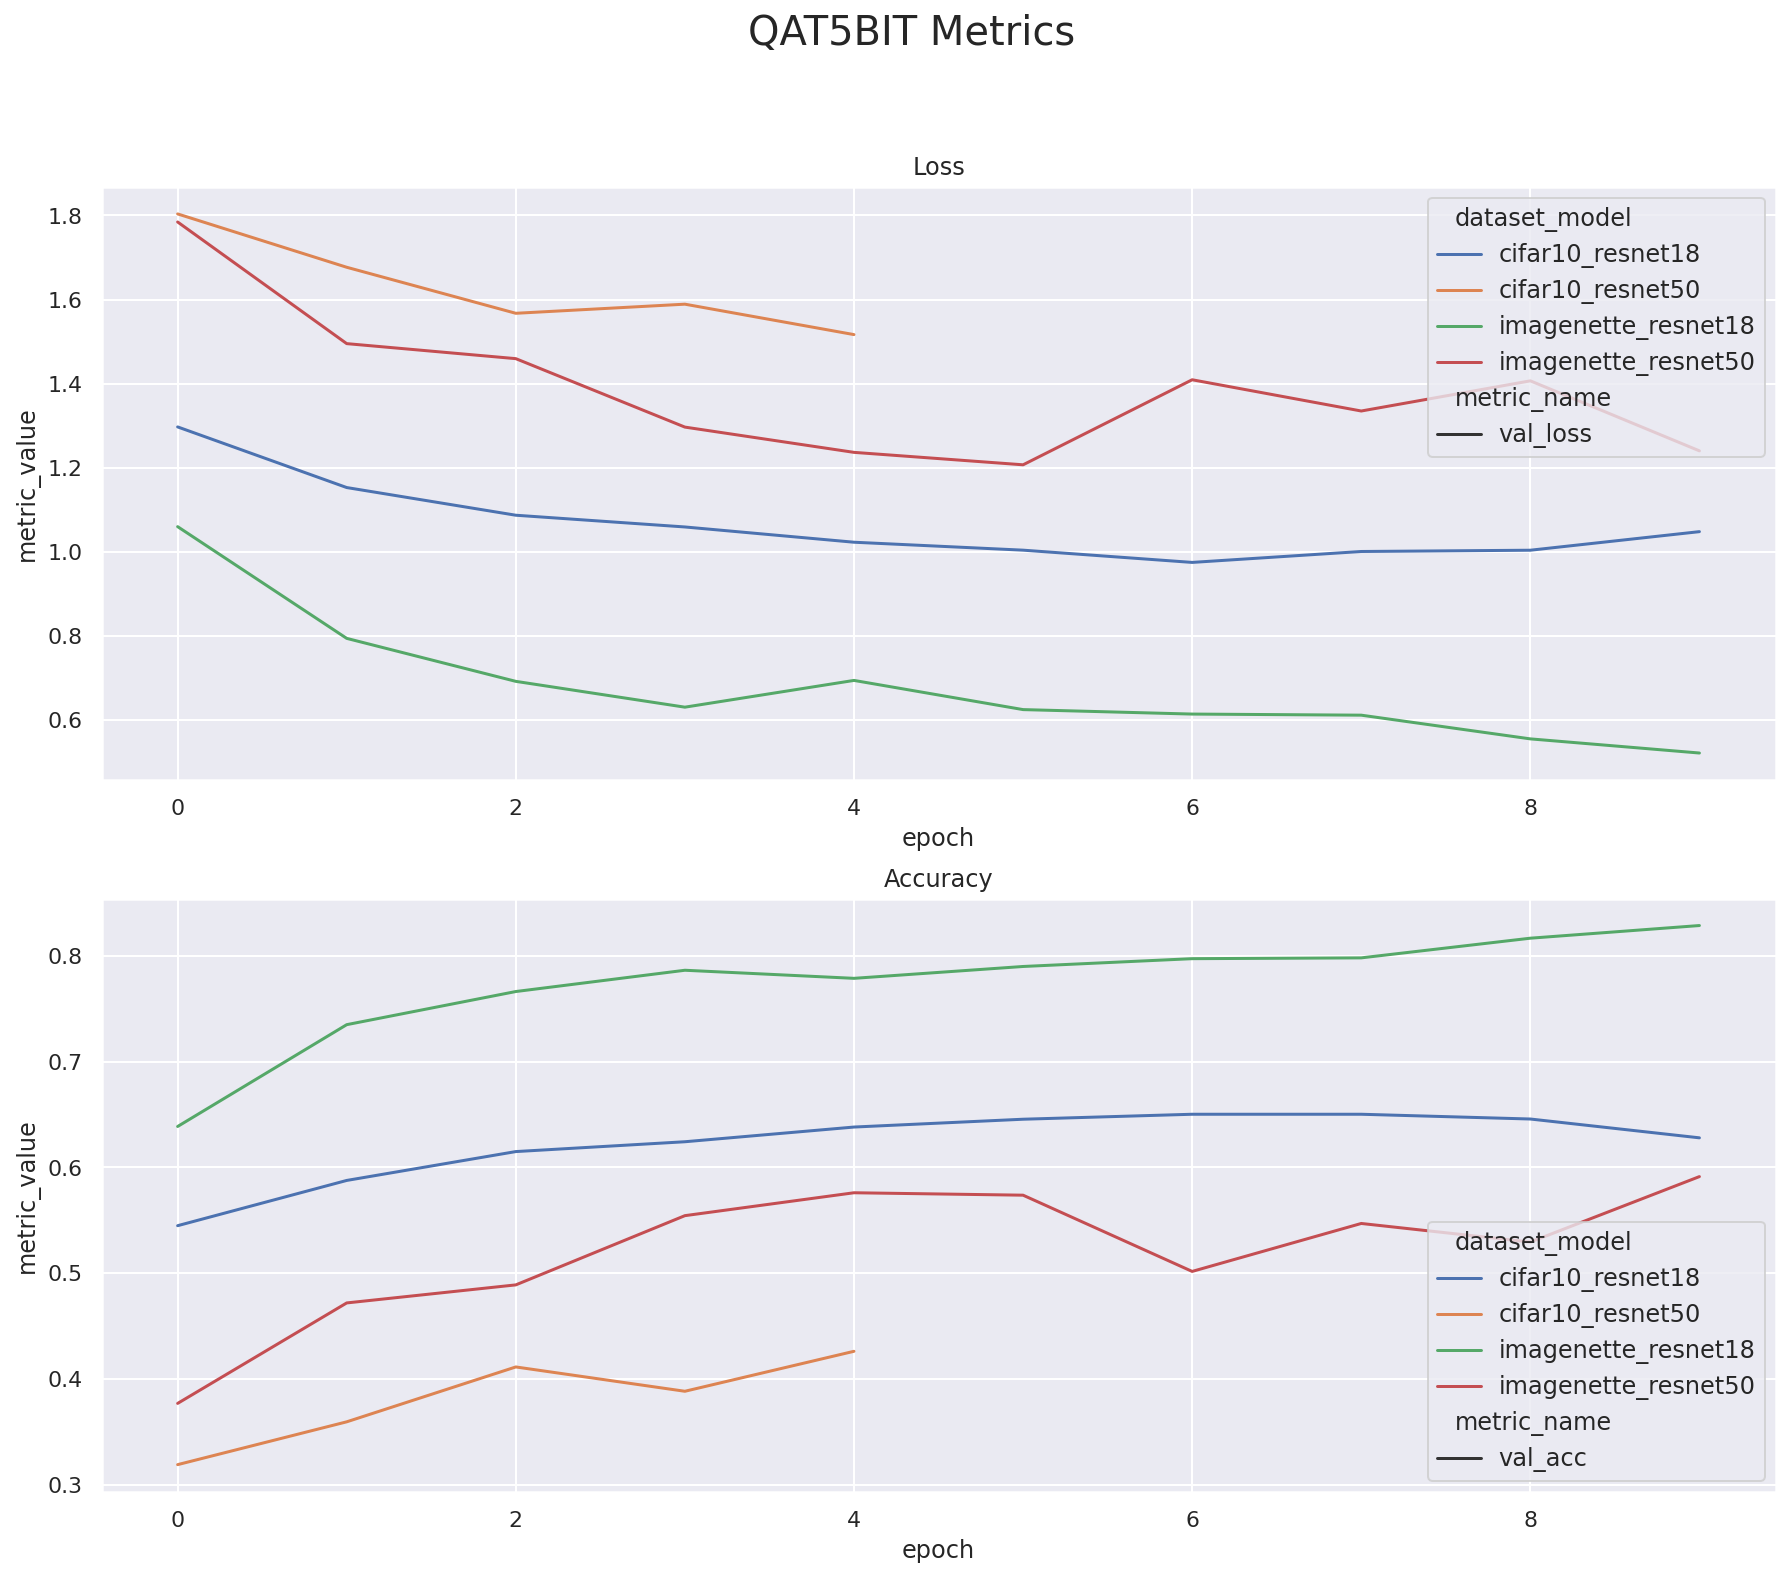

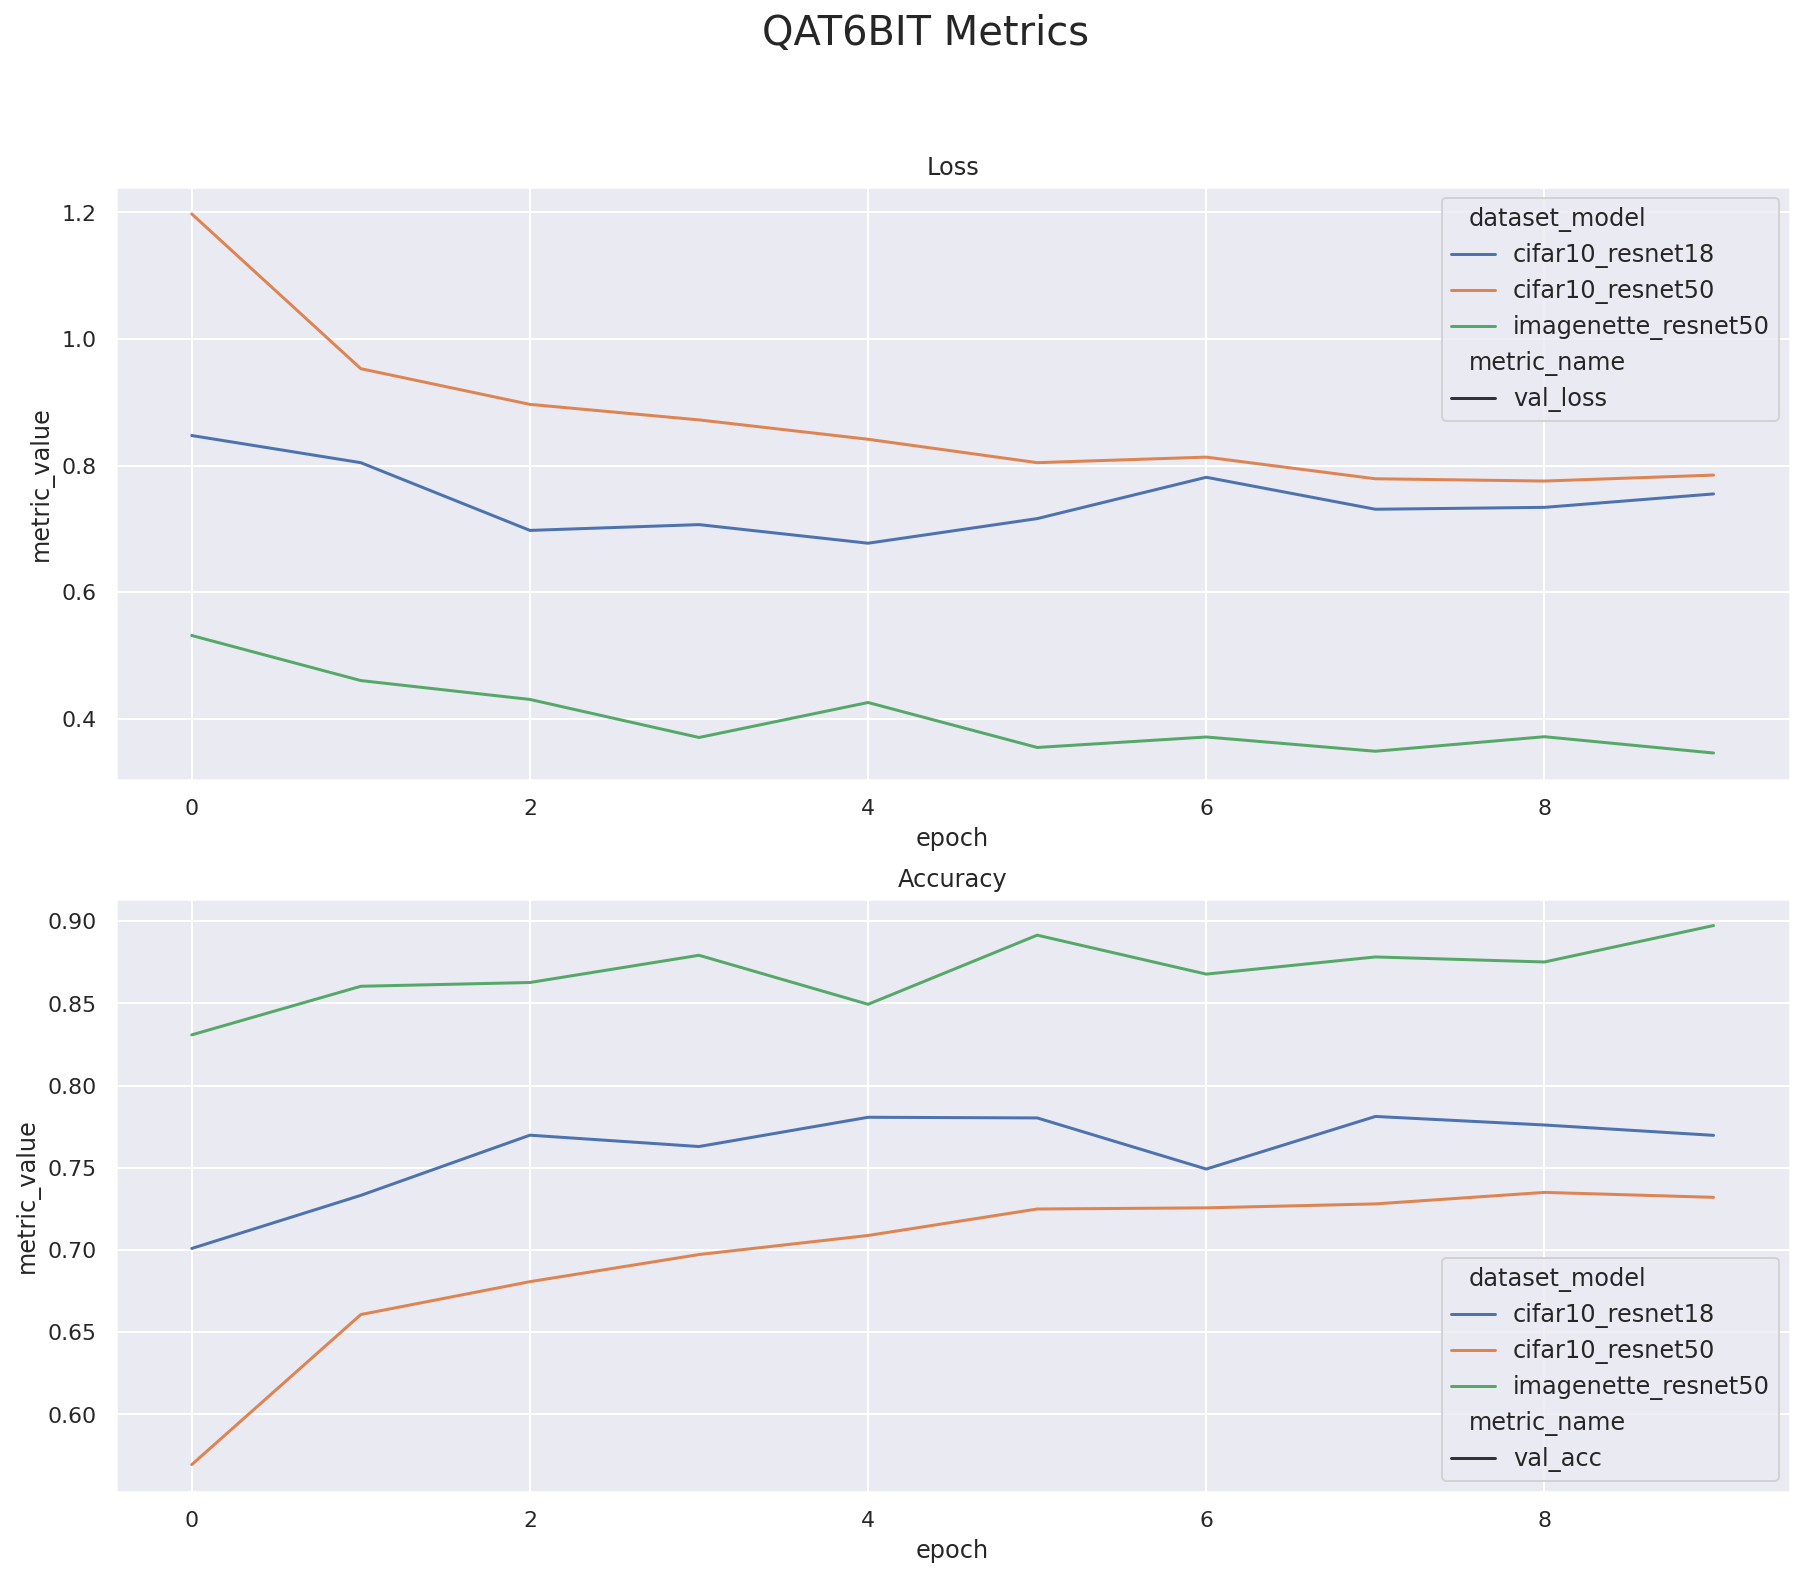

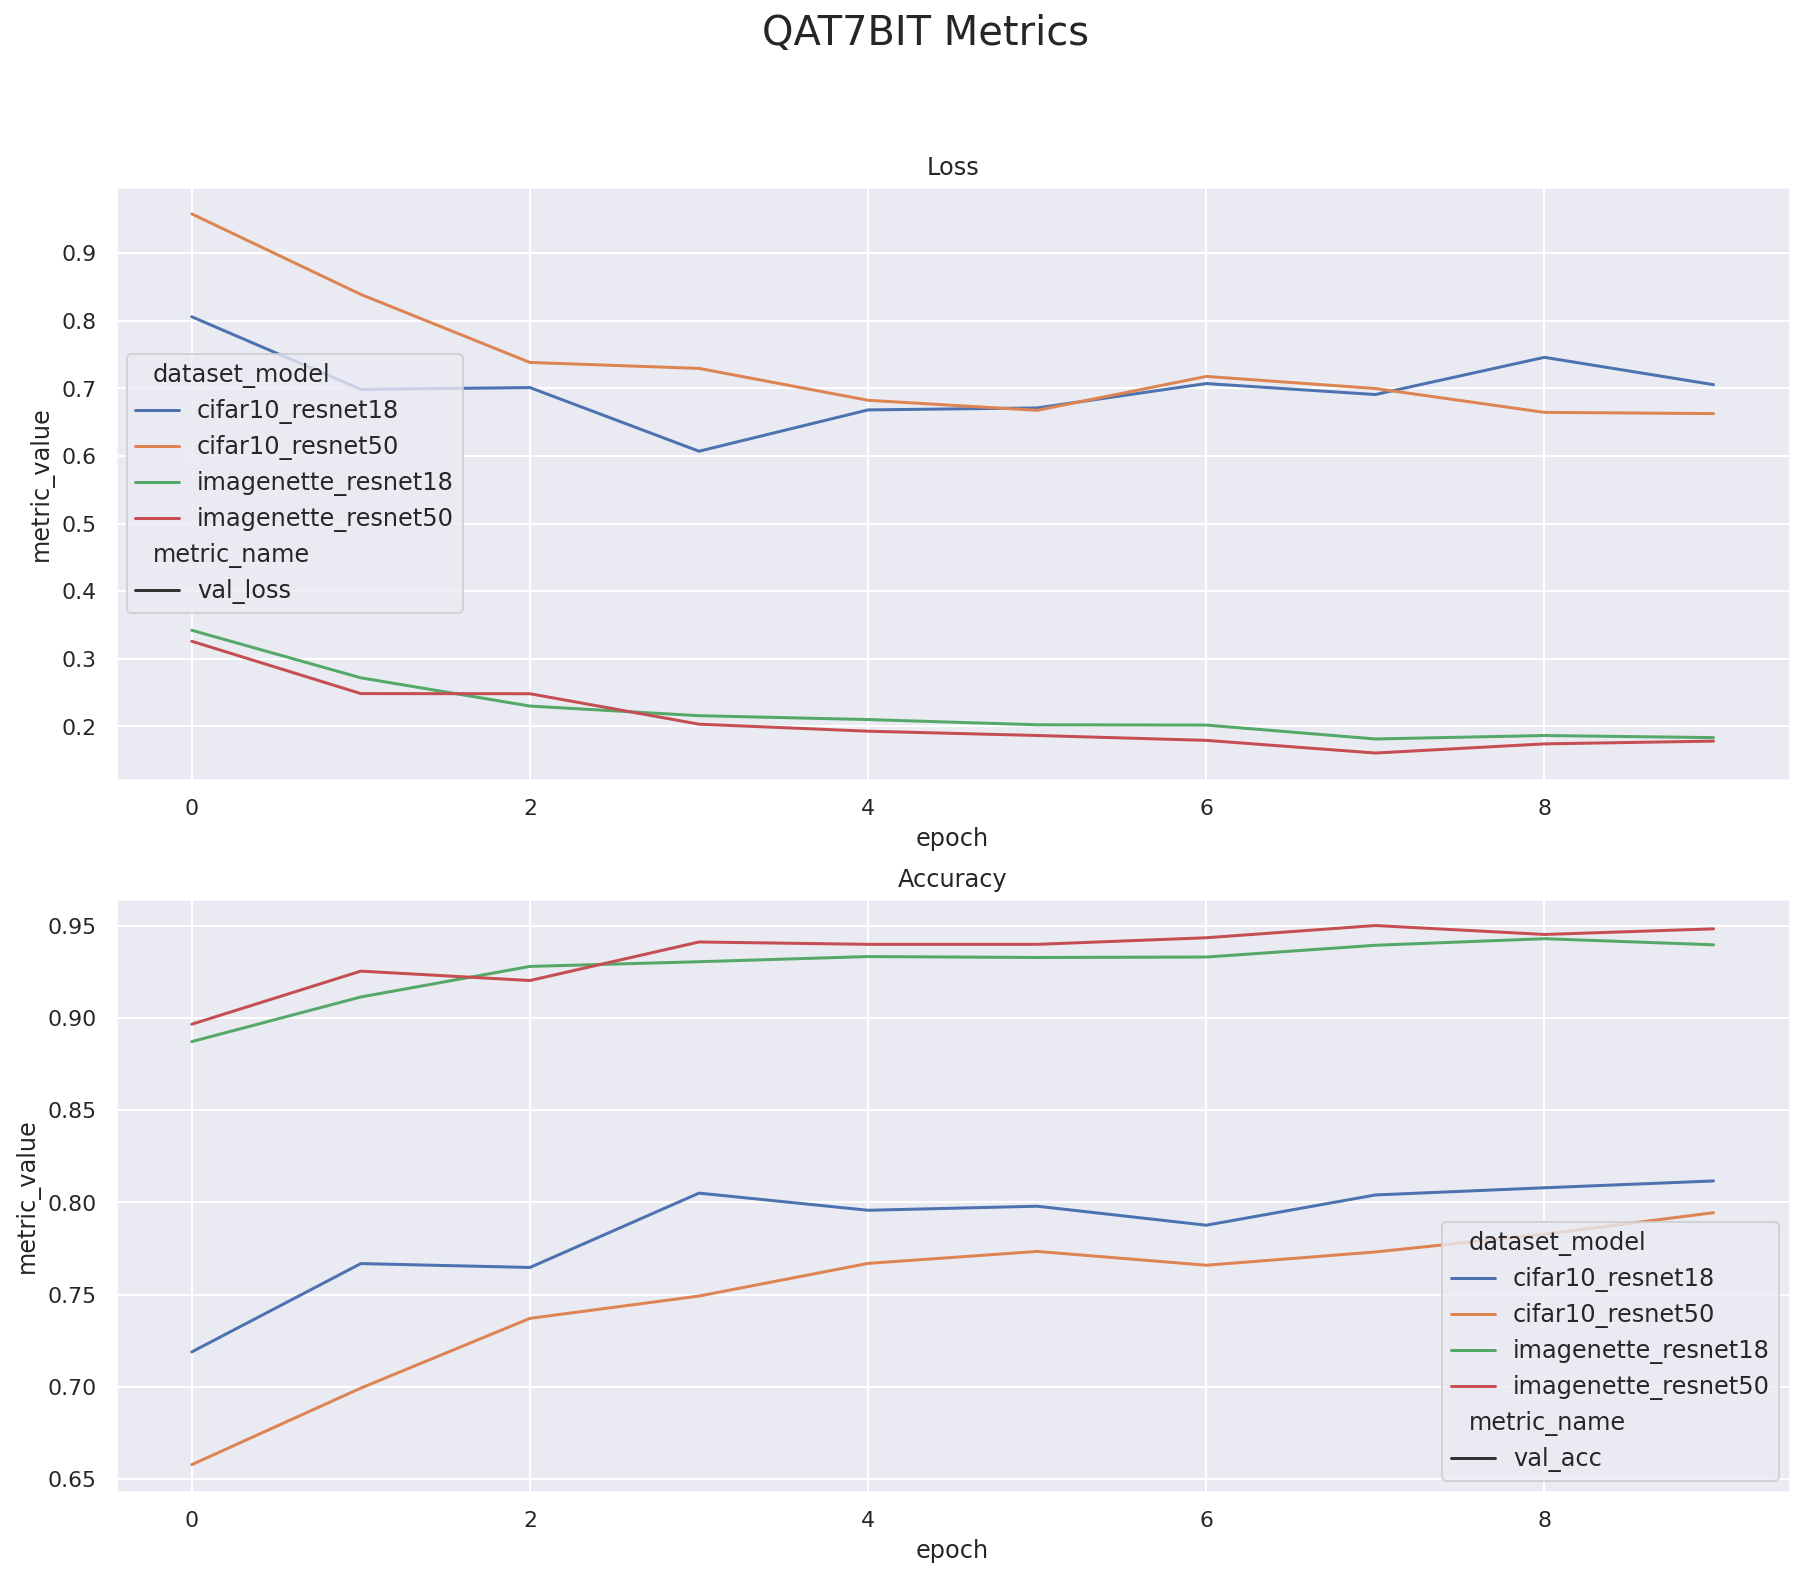

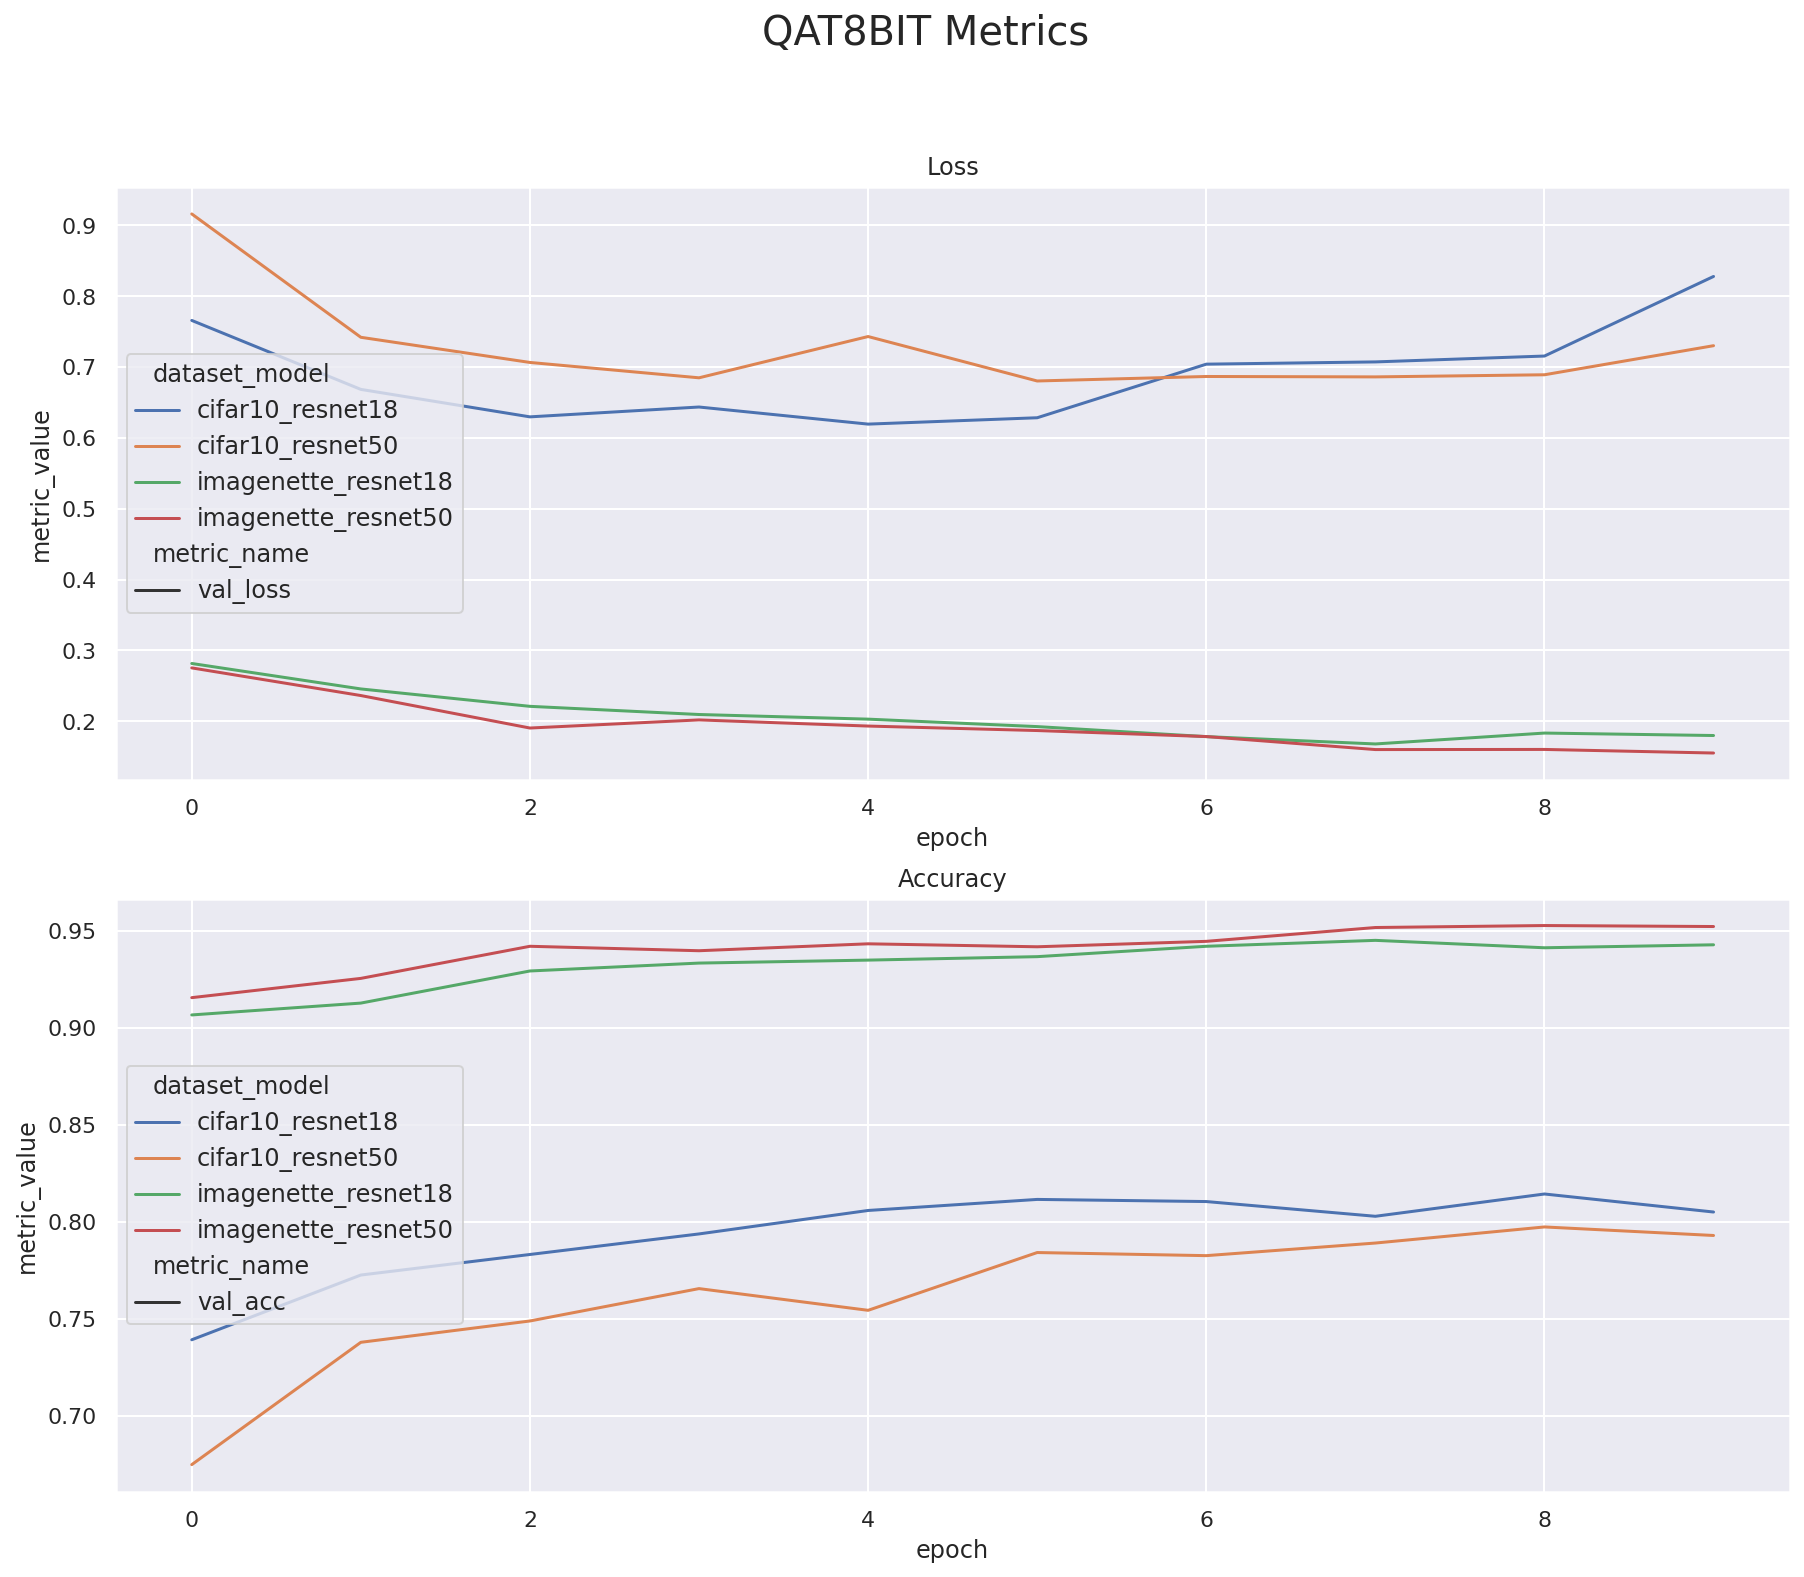

In [9]:
# Per Quantization

for qt in qat_plot['quantization'].unique():
    fig, ax = plt.subplots(figsize=(15,12), nrows=2, ncols=1)
    sns.lineplot(data=qat_plot[(qat_plot['quantization']==qt)&
                               (qat_plot['metric_name'].str.contains('val_loss'))], 
                    x='epoch', y='metric_value', hue='dataset_model', style='metric_name', ax=ax[0])
    sns.lineplot(data=qat_plot[(qat_plot['quantization']==qt)&
                               (qat_plot['metric_name'].str.contains('val_acc'))], 
                    x='epoch', y='metric_value', hue='dataset_model', style='metric_name', ax=ax[1])
    fig.suptitle(f"{qt.upper()} Metrics", fontsize=20)
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    plt.savefig(f'figures/effect_of_diff_models/{qt}.png', dpi=500)